In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')#,force_remount=True)

Mounted at /content/drive


In [2]:
! nvidia-smi

Sun May 16 16:20:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Module 1: Pose Estimation**

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os.path as osp
import os
import sys

# add custom modules to system path
def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

this_dir = osp.dirname('/content/drive/My Drive/Myntra_fashion_recommendation/${POSE_ROOT}/pose_estimation/_init_paths.py')

lib_path = osp.join((os.sep).join(this_dir.split(os.sep)[:-1]), 'lib')
add_path(lib_path)

In [5]:
def bbox_center_scale(box, image_width, image_height):
    x, y, w, h = box[:4]
    return get_center_scale(x, y, w, h, image_width, image_height)

def get_center_scale(x, y, w, h, image_width, image_height):
    center = np.zeros((2), dtype=np.float32)
    center[0] = x + w * 0.5
    center[1] = y + h * 0.5
    
    aspect_ratio = image_width * 1.0 / image_height
    pixel_std = 200

    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
    scale = np.array(
        [w * 1.0 / pixel_std, h * 1.0 / pixel_std],
        dtype=np.float32)
    if center[0] != -1:
        scale = scale * 1.25

    return center, scale

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
from easydict import EasyDict as edict
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms

from core.config import config
from core.config import update_config
from core.inference import get_final_preds
from core.loss import JointsMSELoss
from utils.transforms import *
from detector.yolo.human_detector import human_bbox_get
from detector.yolo.human_detector import load_model

import cv2
import models
import numpy as np
from google.colab.patches import cv2_imshow

# network configuration
cfg = '/content/drive/MyDrive/Myntra_fashion_recommendation/${POSE_ROOT}/experiments/coco/resnet50/256x192_d256x3_adam_lr1e-3.yaml'
# update config
update_config(cfg)

# cudnn related setting
cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.enabled = True

# load resnet model
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(
    config, is_train=False
)
# YOLO V3 detection model
yolo_model = load_model() 

# load resnet weights
model_state_file = '/content/drive/MyDrive/Myntra_fashion_recommendation/${POSE_ROOT}/models/pytorch/pose_coco/pose_resnet_50_256x192.pth.tar'
model.load_state_dict(torch.load(model_state_file))

gpus = [int(i) for i in config.GPUS.split(',')]
model = torch.nn.DataParallel(model, device_ids=gpus).cuda()

# define loss function (criterion) and optimizer
criterion = JointsMSELoss(
    use_target_weight=config.LOSS.USE_TARGET_WEIGHT
).cuda()

## INFERENCE
def pose_detect(image_path):
    data_numpy = cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

    if data_numpy is None:
        raise ValueError('Fail to read {}'.format(image_file))

    # detect human bbox
    box, scores = human_bbox_get(data_numpy, yolo_model)
    # check if anything detected
    if len(box)>0:
      c, s = bbox_center_scale(box[0], data_numpy.shape[0], data_numpy.shape[1])
      r = 0

      trans = get_affine_transform(c, s, r, config.MODEL.IMAGE_SIZE)
      input = cv2.warpAffine(
          data_numpy,
          trans,
          (int(config.MODEL.IMAGE_SIZE[0]), int(config.MODEL.IMAGE_SIZE[1])),
          flags=cv2.INTER_LINEAR)


      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
          ])
      input = transform(input).unsqueeze(0)

      # switch to evaluate mode
      model.eval()
      with torch.no_grad():
          # compute output heatmap
          output = model(input)
          
          # compute coordinate
          preds, maxvals = get_final_preds(
              config, output.clone().cpu().numpy(), np.asarray([c]), np.asarray([s]))

          thresh=0.6
          # check if keypoint predictions is greater than threshold
          if maxvals[0][0]>thresh and maxvals[0][1]>thresh and maxvals[0][2]>thresh and maxvals[0][3]>thresh and \
          maxvals[0][4]>thresh and maxvals[0][15]>thresh and maxvals[0][16]>thresh:
            print("FULL POSE")
            return True
          else:
            print("NOT A FULL POSE")
            return False
        
      # display image
      # cv2_imshow(data_numpy)
    else:
      print("NOT A FULL POSE")
      return False
      # cv2_imshow(data_numpy)

Loading network.....
Network successfully loaded


# **Module 2: Fashion item detection**

In [7]:
import os
import sys

mask_rcnn_path = '/content/drive/My Drive/Myntra_fashion_recommendation/Mask_RCNN'
# os.chdir(mask_rcnn_path)
sys.path.append(mask_rcnn_path)

In [8]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from PIL import Image, ImageDraw

NUM_CATS = 46
IMAGE_SIZE = 512
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

class DeepFashionConfig(Config):
    NAME = "deepfashion"
    # +1 for the background class
    NUM_CLASSES = NUM_CATS + 1 
    
    GPU_COUNT = 1
    # a memory error occurs when IMAGES_PER_GPU is too high
    IMAGES_PER_GPU = 2 
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200

    USE_MINI_MASK=False
    
class InferenceConfig(DeepFashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

model_weights = '/content/drive/My Drive/Myntra_fashion_recommendation/Mask_RCNN/mask_rcnn_fashion_0008.h5'

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=os.getcwd())

# load trained model weights    
model.load_weights(filepath=model_weights,
                   by_name=True)

Instructions for updating:
Use fn_output_signature instead


In [9]:
# list of all fashion items
label_names = ['shirt, blouse','top, t-shirt, sweatshirt','sweater','cardigan',
 'jacket','vest','pants','shorts','skirt','coat','dress','jumpsuit','cape','glasses','hat',
 'headband, head covering, hair accessory','tie','glove', 'watch', 'belt', 'leg warmer', 'tights, stockings',
 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve',
 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon',
 'rivet', 'ruffle', 'sequin', 'tassel']

# combine subcategories
feet = ['shoe']
upperbody = ['cardigan','collar','hood','jacket','neckline','shirt, blouse','sleeve','sweater',
             'top, t-shirt, sweatshirt','vest',]
lowerbody = ['pants', 'pocket', 'shorts', 'skirt','stockings','tights', 'leg warmer']
wholebody = ['cape', 'coat', 'dress', 'jumpsuit','dress']

NUM_CATS = 46
IMAGE_SIZE = 512

def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

# get bounding box predictions
def get_box(path):
    image_path = path
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                      (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
      
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
      
        masks, rois = refine_masks(masks, rois)
        return img, masks, rois, r
    else:
        masks, rois = r['masks'], r['rois']
        return img,masks, rois, r

# modify display_instances function to get all fashion items in an image
# https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py
def get_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    masked_image = image.astype(np.uint32).copy()

    feet_temp = []
    upperbody_temp = []
    lowerbody_temp = []
    wholebody_temp = []

    for i in range(N):
        # Check bounding boxes
        if not np.any(boxes[i]):
            # Skip this instance if there is no bbox.
            continue
        y1, x1, y2, x2 = boxes[i]
        # Check Labels
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
            # confidence threshold
            if score>0.75:
                if label in feet:
                    feet_temp.append((y1, x1, y2, x2))
                if label in upperbody:
                    upperbody_temp.append((y1, x1, y2, x2))
                if label in lowerbody:
                    lowerbody_temp.append((y1, x1, y2, x2))
                if label in wholebody:
                    wholebody_temp.append((y1, x1, y2, x2))
        else:
            caption = captions[i]
    
    return  feet_temp ,upperbody_temp,lowerbody_temp , wholebody_temp

# crop items from the bounding boxes
def crop(y1,x1,y2,x2,img):
    outimage = img[int(y1):int(y2), int(x1):int(x2)]
    return outimage

# get pixel cordinates of each fashion item for cropping
def get_min_max(li,no,typee):
    mini = []
    for i in li:
        mini.append(i[no])
    if typee=='min': 
        return min(mini)
    if typee=='max':
        return max(mini)

# get cropped images
def get_crop_image(img,li,name):
    images = []
    if name=='feet':
        for i in li:
            outimage = crop(i[0],i[1],i[2],i[3],img)
            images.append(outimage)
    if name=='full':
        for i in li:
            outimage = crop(i[0],i[1],i[2],i[3],img)
            images.append(outimage)
    if name=='upp':
        y1 = get_min_max(li,0,'min')
        x1 = get_min_max(li,1,'min')
        y2 = get_min_max(li,2,'max')
        x2 = get_min_max(li,3,'max')
        outimage = crop(y1,x1,y2,x2,img)
        images.append(outimage)

    if name=='bott':
        y1 = get_min_max(li,0,'min')
        x1 = get_min_max(li,1,'min')
        y2 = get_min_max(li,2,'max')
        x2 = get_min_max(li,3,'max')
        outimage = crop(y1,x1,y2,x2,img)
        images.append(outimage)
    return images

# function to detect all types of fashion items
def object_detections(path):
    img , masks, rois, r = get_box(path)
    feet_temp ,upperbody_temp,lowerbody_temp , wholebody_temp = get_instances(img, rois, masks, r['class_ids'], 
                              ['bg']+label_names, r['scores'],
                              title=path, figsize=(12, 12),show_mask=False)
    feet_images = []
    whole_images = []
    upperbody_images = []
    lowerbody_images = []
    if len(feet_temp)>0:
        feet_images = get_crop_image(img,feet_temp,'feet')
    if len(wholebody_temp)>0:
        whole_images = get_crop_image(img,wholebody_temp,'full')
    if len(upperbody_temp)>0:
        upperbody_images = get_crop_image(img,upperbody_temp,'upp')
    if len(lowerbody_temp)>0:
        lowerbody_images = get_crop_image(img,lowerbody_temp,'bott')
  
    return img , masks, rois, r , feet_images, whole_images, upperbody_images, lowerbody_images

# **Module 3: Item similarity**

In [14]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
import datetime as dt
import cv2
import numpy as np

model_embedding = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(512,512,3),
    pooling=None,
)

29089792/29084464 [==============================] - 1s 0us/step


In [15]:
def get_embeddings(img):
  # load image
  img = cv2.resize(img,(512,512),interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...] 

  op = model_embedding.predict(img,steps=1)
  op = tf.squeeze(op, axis=None, name=None)
  op = tf.reduce_mean(op, axis=(0,1), keepdims=False, name=None)
  op = op.eval(session=tf.compat.v1.Session())
  op = op.tolist()
  return op

def plot_images(li, df):
  for i in range(len(li[0])): 
    print(f'image id:{li[0][i]}')
    outimage = cv2.imread(df['image_path'].iloc[li[0][i]])
    cv2_imshow(outimage)

## Retrieve the stored image embeddings

In [16]:
import pickle
with open('/content/drive/MyDrive/Myntra_fashion_recommendation/deepfashion_embeddings.pickle','rb') as f:
  df = pickle.load(f)

In [17]:
%%time
import faiss

# creating different indices for different apparel styles
upperbody_df = df[df.image_path.apply(lambda x: x.split(os.sep)[-2])=='final_upper']
lowerbody_df = df[df.image_path.apply(lambda x: x.split(os.sep)[-2])=='final_lower']
wholebody_df = df[df.image_path.apply(lambda x: x.split(os.sep)[-2])=='final_whole']

# embeddings of different apparel styles
upperbody_image_embedding=list(upperbody_df.description_vector)
lowerbody_image_embedding=list(lowerbody_df.description_vector)
wholebody_image_embedding=list(wholebody_df.description_vector)

# Step 1: Change data type
upperbody_embeddings = np.array([embedding for embedding in upperbody_image_embedding]).astype("float32")
lowerbody_embeddings = np.array([embedding for embedding in lowerbody_image_embedding]).astype("float32")
wholebody_embeddings = np.array([embedding for embedding in wholebody_image_embedding]).astype("float32")

# reference: https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances#how-can-i-index-vectors-for-cosine-similarity
# Step 2: Instantiate the index
upperbody_index = faiss.IndexFlatIP(upperbody_embeddings.shape[1])
lowerbody_index = faiss.IndexFlatIP(lowerbody_embeddings.shape[1])
wholebody_index = faiss.IndexFlatIP(wholebody_embeddings.shape[1])
# normalize the vectors for cosine similarity
faiss.normalize_L2(x=upperbody_embeddings)
faiss.normalize_L2(x=lowerbody_embeddings)
faiss.normalize_L2(x=wholebody_embeddings)

# Step 3: Pass the index to IndexIDMap
upperbody_index = faiss.IndexIDMap(upperbody_index)
lowerbody_index = faiss.IndexIDMap(lowerbody_index)
wholebody_index = faiss.IndexIDMap(wholebody_index)

# Step 4: Add vectors and their IDs
upperbody_index.add_with_ids(upperbody_embeddings, np.arange(len(upperbody_image_embedding)))
lowerbody_index.add_with_ids(lowerbody_embeddings, np.arange(len(lowerbody_image_embedding)))
wholebody_index.add_with_ids(wholebody_embeddings, np.arange(len(wholebody_image_embedding)))

CPU times: user 337 ms, sys: 75.6 ms, total: 412 ms
Wall time: 464 ms


# **FINAL FUNCTION (COMPLETE PIPELINE):-**

In [21]:
def final_fn(image_path):
  # MODULE 1: POSE DETECTION
  # is_full_image = pose_detect(image_path)
  # if not is_full_image:
  #   print('NOT FULL SHOT IMAGE')  

  # MODULE 2: FASHION ITEMS DETECTION
  img , masks, rois, r , feet_images, wholebody_images, upperbody_images, lowerbody_images = object_detections(image_path)
  
  # find similar upperbody images
  if len(upperbody_images)>0:
    print('UPPERBODY PRODUCTS:-')
    # show upperbody images
    for i in upperbody_images:
      outimage = i
      i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
      i = cv2.resize(i,(512,512))
      cv2_imshow(i)
      # find similar images
      print('RECOMMENDED PRODUCTS:-')
      query_vector = get_embeddings(i)
      # find top 3 similar images
      distances, indices = upperbody_index.search(np.array([query_vector]).astype("float32"), k=3)
      # show recommendations
      plot_images(indices, upperbody_df)

  # find similar wholebody_images
  if len(wholebody_images)>0:
    print('WHOLEBODY PRODUCTS:-')
    # show wholebody images
    for i in wholebody_images:
      outimage = i
      i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
      i = cv2.resize(i,(512,512))
      cv2_imshow(i)
      # find similar images
      print('RECOMMENDED PRODUCTS:-')
      query_vector = get_embeddings(i)
      # find top 3 similar images
      distances, indices = wholebody_index.search(np.array([query_vector]).astype("float32"), k=3)
      # show recommendations
      plot_images(indices, wholebody_df)

  # find similar lowerbody images
  if len(lowerbody_images)>0:
    print('LOWERBODY PRODUCTS:-')
    # show lowerbody images
    for i in lowerbody_images:
      outimage = i
      i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
      i = cv2.resize(i,(512,512))
      cv2_imshow(i)
      # find similar images
      print('RECOMMENDED PRODUCTS:-')
      query_vector = get_embeddings(i)
      # find top 3 similar images
      distances, indices = lowerbody_index.search(np.array([query_vector]).astype("float32"), k=3)
      # show recommendations
      plot_images(indices, lowerbody_df)
    
  # find similar footwear images
  if len(feet_images)>0:
    print('Footwear PRODUCTS:-')
    # show footwear images
    for i in feet_images:
      outimage = i
      i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
      i = cv2.resize(i,(512,512))
      cv2_imshow(i)
      # find similar images
      print('RECOMMENDED PRODUCTS:-')
      query_vector = get_embeddings(i)
      # find top 3 similar images
      distances, indices = lowerbody_index.search(np.array([query_vector]).astype("float32"), k=3)
      # show recommendations
      plot_images(indices, lowerbody_df)
      break

## **INFERENCE:-**

UPPERBODY PRODUCTS:-


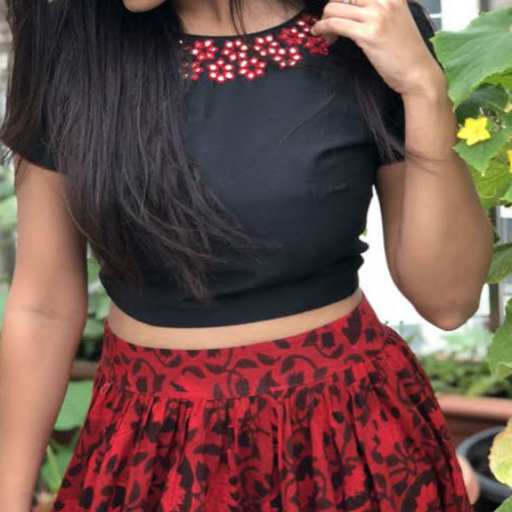

RECOMMENDED PRODUCTS:-
image id:1838


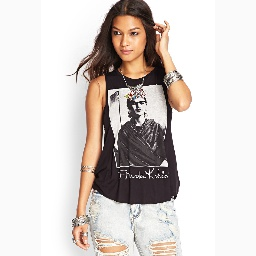

image id:1884


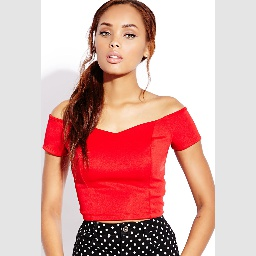

image id:1306


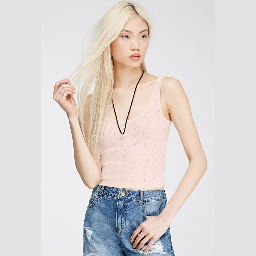

WHOLEBODY PRODUCTS:-


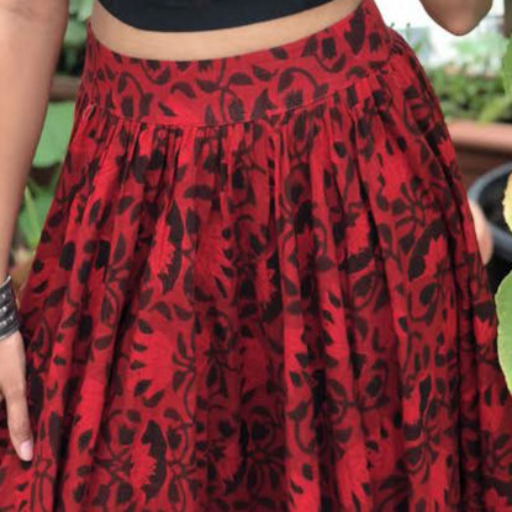

RECOMMENDED PRODUCTS:-
image id:1388


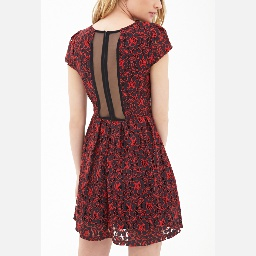

image id:1911


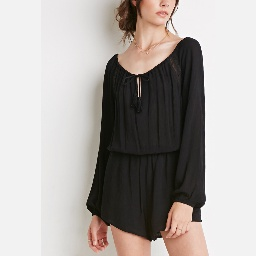

image id:614


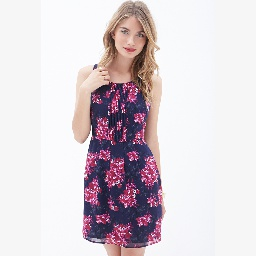

In [22]:
image_path = '/content/drive/MyDrive/Myntra_fashion_recommendation/deepfashion_data/women_dress.jpg'
final_fn(image_path)